In [1]:
import glob
import numpy as np
import os
import os.path as path
import imageio

In [2]:
IMAGE_PATH = 'FoodImageSampling3/'
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))

In [3]:
file_paths[:10]

['FoodImageSampling3\\0_0.png',
 'FoodImageSampling3\\0_0C366088-5D26-4B25-81DE-CBE219D91C8E-1.png',
 'FoodImageSampling3\\0_0C366088-5D26-4B25-81DE-CBE219D91C8E.png',
 'FoodImageSampling3\\0_1.png',
 'FoodImageSampling3\\0_10.png',
 'FoodImageSampling3\\0_100.png',
 'FoodImageSampling3\\0_1000.png',
 'FoodImageSampling3\\0_1001.png',
 'FoodImageSampling3\\0_1002.png',
 'FoodImageSampling3\\0_1003.png']

In [4]:
images = [imageio.imread(path) for path in file_paths]
images = np.asarray(images)

In [5]:
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

[20 20  3]


In [6]:
images = images / 255

In [7]:
# Read the labels from the filenames
# 해당이미지면1을, 아니면 0을 라벨링.
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

In [8]:
# Split into test and training sets
TRAIN_TEST_SPLIT = 0.9

In [9]:
# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

In [10]:
# Split the images and the labels
x_train = images[train_indices, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :]
y_test = labels[test_indices]

In [11]:
import matplotlib.pyplot as plt

In [12]:
# 시각화 함수 정의
# 양성 샘플 이미지를 위에, 음성샘플 이미지를 아래에 배열, 텍스트는 라벨을 나타냄
def visualize_data(positive_images, negative_images):
 
    # INPUTS
    # positive_images - Images where the label = 1 (True)
    # negative_images - Images where the label = 0 (False)
 
    figure = plt.figure()
    count = 0
 
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")
 
        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
        
    plt.show()

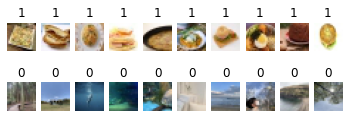

In [13]:
# Number of positive and negative examples to show
N_TO_VISUALIZE = 10
 
# Select the first N positive examples
positive_example_indices = (y_train == 1)
positive_examples = x_train[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]
 
# Select the first N negative examples
negative_example_indices = (y_train == 0)
negative_examples = x_train[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]
 
# Call the visualization function
visualize_data(positive_examples, negative_examples)

In [14]:
# Imports
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime


Using TensorFlow backend.
C:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\anaconda3\envs\tensor\lib\sit

In [15]:
# Hyperparamater
# 모델 성능을 개선하기 위한 사용자 정의값
# CNN이 몇개의 합성곱 레이어를 가질 것인가에 대한 정의값
N_LAYERS = 4

In [16]:
def cnn(size, n_layers):
    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN
 
    # Define hyperparamters
    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)
 
    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)
 
    # Define a model
    model = Sequential()
 
    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))
 
        model.add(Activation('relu'))
 
    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))
 
    # Add output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
 
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
 
    # Print a summary of the model
    model.summary()
 
    return model


In [17]:
model = cnn(size=image_size, n_layers=N_LAYERS)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 20)        560       
_________________________________________________________________
activation_1 (Activation)    (None, 18, 18, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 44)        7964      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 44)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 68)        26996     
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 68)        0         
_________________________

In [18]:
# Training hyperparamters
EPOCHS = 150
BATCH_SIZE = 200

In [19]:
# Early stopping callback
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')

In [20]:
# TensorBoard callback
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)


In [21]:
# Place the callbacks in a list
callbacks = [early_stopping, tensorboard]

In [22]:
# Train the model
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=0)

In [23]:
# Make a prediction on the test set
test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)

In [24]:
# Make a prediction on the test set
test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)

In [25]:
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.9771863117870723


C:\Users\Admin\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


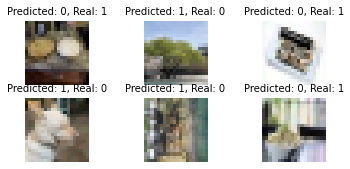

In [34]:
import matplotlib.pyplot as plt
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]
 
    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))
 
    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)
 
    plt.show()
 
visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())

In [27]:
from keras.models import load_model
model.save('food_model.h5')
print("Saved classifier to disk")

Saved classifier to disk


In [28]:
from keras.models import load_model
airmodel = load_model('food_model.h5')

In [29]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('food_model.tflite', 'wb') as f:
  f.write(tflite_model)

AttributeError: type object 'TFLiteConverter' has no attribute 'from_keras_model'